In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import json
import pickle
from collections import defaultdict
%matplotlib inline

In [2]:
np.random.seed(21)

In [3]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Activation, Cropping2D, Reshape, BatchNormalization
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras.losses import mean_squared_error, categorical_crossentropy
from keras.preprocessing.image import Iterator
from keras.utils.np_utils import to_categorical
from keras.layers import Reshape, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

import tensorflow as tf
sess = tf.Session()
K.set_session(sess)

Using TensorFlow backend.


In [4]:
from __future__ import absolute_import
from __future__ import print_function

from pkg_resources import parse_version
from keras.callbacks import Callback

In [5]:
class TensorBoardCallBack(Callback):
    """Tensorboard basic visualizations.
    This callback writes a log for TensorBoard, which allows
    you to visualize dynamic graphs of your training and test
    metrics, as well as activation histograms for the different
    layers in your model.
    TensorBoard is a visualization tool provided with TensorFlow.
    If you have installed TensorFlow with pip, you should be able
    to launch TensorBoard from the command line:
    ```
    tensorboard --logdir=/full_path_to_your_logs
    ```
    You can find more information about TensorBoard
    [here](https://www.tensorflow.org/versions/master/how_tos/summaries_and_tensorboard/index.html).
    # Arguments
        log_dir: the path of the directory where to save the log
            files to be parsed by Tensorboard
        batch_freq: frequency (in batch) at which to log data
            If set to 0, we just log at the end of an epoch,
    """

    def __init__(self, log_dir='./logs',
                 batch_freq=0):
        super(TensorBoardCallBack, self).__init__()

        self.log_dir = log_dir
        self.batch_freq = batch_freq
        self.merged = None
        self.writer = tf.summary.FileWriter(self.log_dir)
        self.last_batch = 0
        self.batch_offset = 0

    def set_model(self, model):
        self.model = model
        self.sess = K.get_session()

        if hasattr(tf, 'merge_all_summaries'):
            self.merged = tf.merge_all_summaries()
        else:
            self.merged = tf.summary.merge_all()

    def on_batch_end(self, batch, logs=None):
        # Each time we go back to batch 0, we increase the batch_offset
        if batch < self.last_batch:
            self.batch_offset += self.last_batch + 1
        self.last_batch = batch

        batch_cross_epoch = self.batch_offset + batch
        if batch_cross_epoch % self.batch_freq == 0:
            logs = logs or {}

            for name, value in logs.items():
                if name in ['batch', 'size']:
                    continue
                summary = tf.Summary()
                summary_value = summary.value.add()
                summary_value.simple_value = value.item()
                summary_value.tag = name
                self.writer.add_summary(summary, batch_cross_epoch)
            self.writer.flush()

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for name, value in logs.items():
            if name in ['batch', 'size']:
                continue
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.writer.add_summary(summary, epoch)
        self.writer.flush()

    def on_train_end(self, _):
        self.writer.close()

In [6]:
def unet_down_block(x, n_filters, block_id, with_maxpool=True, activation="elu"):
    y = Conv2D(n_filters, (3, 3), activation=activation, 
               padding='same', name="conv{}_1".format(block_id))(x)
    y = BatchNormalization(name="bn{}_1".format(block_id))(y)
    
    y = Conv2D(n_filters, (3, 3), activation=activation,
               padding='same', name="conv{}_2".format(block_id))(y)
    conv = BatchNormalization(name="bn{}_2".format(block_id))(y)
    
    if not with_maxpool:
        return conv
    
    pool = MaxPooling2D(pool_size=(2, 2), name="max_pool{}".format(block_id))(conv)   
    return conv, pool    

In [7]:
def get_lowiknet(n_channels=3, n_classes=6,
             n_filters=[64, 128, 256, 512, 1024]):
    inputs = Input((None, None, n_channels))
    
    conv1, pool1 = unet_down_block(inputs, n_filters[0], 1)
    conv2, pool2 = unet_down_block(pool1,  n_filters[1], 2)
    conv3, pool3 = unet_down_block(pool2,  n_filters[2], 3)
    conv4, pool4 = unet_down_block(pool3,  n_filters[3], 4)
    conv5 = unet_down_block(pool4, n_filters[4], 5, with_maxpool=False)
    conv10 = Conv2D(n_classes, (5, 5), activation='softmax')(conv5)
    model = Model(inputs=[inputs], outputs=[conv10])

    return model

In [8]:
sealion_net = get_lowiknet(3, n_filters=[32, 64, 128, 256, 512])

In [9]:
t = np.ones((1, 80, 80, 3))
sealion_net.predict(t).shape

(1, 1, 1, 6)

In [11]:
sealion_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, None, None, 32)    896       
_________________________________________________________________
bn1_1 (BatchNormalization)   (None, None, None, 32)    128       
_________________________________________________________________
conv1_2 (Conv2D)             (None, None, None, 32)    9248      
_________________________________________________________________
bn1_2 (BatchNormalization)   (None, None, None, 32)    128       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, None, None, 32)    0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, None, None, 64)    18496     
__________

In [12]:
class NonValidPatch(Exception):
    pass

In [13]:
def get_block_loc(shape, x, y, target_size=(396, 396), n_blocks=(4,4), overlap=(448,448)):
    h, w = shape
    w_block = (w + (n_blocks[1] - 1) * overlap[1]) // n_blocks[1]
    h_block = (h + (n_blocks[0] - 1) * overlap[0]) // n_blocks[0]
    for by in range(n_blocks[0]):
        y_start = by * (h_block - overlap[0])
        y_end = y_start + h_block + 1
        for bx in range(n_blocks[1]):
            x_start = bx * (w_block - overlap[1])
            x_end = x_start + w_block + 1
            
            if x_start <= x < x_end and y_start <= y < y_end and\
            x_start <= x + target_size[1] - 1 < x_end and y_start <= y + target_size[0] - 1 < y_end:
                return bx + by * n_blocks[0], x - x_start, y - y_start
    raise NonValidPatch("Can't find block...??")

In [14]:
class PatchesIterator(Iterator):
    """Iterator yielding training samples of subadult_males
    :param root_dir: Directory containing training images, and dots.
    :param image_ids: Set of image ids to use to sample patches.
    :param class_weights: Weights for each class.
    :param n_samples_per_image: Number of patches to sample on each image.
    :param target_size: Size of the patches sampled.
    :param batch_size: Number of patches sampled per batch
    :param shuffle: Boolean, whether to shuffle the data between epochs.
    :param seed: Random seed for data shuffling.
    :return batch_x, batch_x. 
        batch_x is a (batch_size, target_size[0], target_size[1], 3) array
        batch_x is a (batch_size, target_size[0], target_size[1], 1) array if output_counts is False
        otherwise, it is a (batch_size, 5) array.
    """

    def __init__(self, root_dir, image_ids,
                 class_weights = None,
                 n_samples_per_image=160,
                 target_size=(80, 80),
                 batch_size=64, shuffle=True, seed=42, debug_dir=None):
        self.n_samples_per_block = 16
        self.n_sealion_types = 5
        self.image_ids = image_ids
        self.root_dir = root_dir
        self.debug_dir = debug_dir
        # Normalize to use class_weights as a probability distribution.
        if class_weights:
            self.class_weights = np.asarray(class_weights)/np.sum(class_weights)
        else:
            self.class_weights = np.ones((self.n_sealion_types+1))/(self.n_sealion_types + 1)
            
        self.n_samples_per_image = n_samples_per_image
        self.target_size = target_size
        self.n_indices = len(self.image_ids) * self.n_samples_per_image
                 
        super(PatchesIterator, self).__init__(self.n_indices, batch_size//self.n_samples_per_block, shuffle, seed)
        
    def get_class_distribution(self, n_batches=100):
        counts = defaultdict(int)
        for _ in range(n_batches):
            _, by = self.next()
            by = np.argmax(by, axis=-1)
            cls, cnts = np.unique(by.ravel(), return_counts=True)
            for c, cnt in zip(cls, cnts):
                counts[c] += cnt
        return counts
        
    def normalize_input(self, x_bgr):
        x = x_bgr.copy()
        x[..., 0] -= 103.939
        x[..., 1] -= 116.779
        x[..., 2] -= 123.68
        return x
    
    def denormalize_input(self, x_normed):
        x = x_normed.copy()
        x[..., 0] += 103.939
        x[..., 1] += 116.779
        x[..., 2] += 123.68
        return x

    def random_transform(self, x):
        flips = np.random.randint(0, 2, (3,))
        if flips[0]:
            x = np.rot90(x)
        if flips[1]:
            x = np.flipud(x)
        if flips[2]:
            x = np.fliplr(x)
        return x
    
    def get_weights(self, dots):
        # Set probability to 0 if some sealion type is not in the block
        current_weigths = self.class_weights.copy()
        for i in range(self.n_sealion_types):
            if not dots[i]:
                current_weigths[i] = 0
        current_weigths /= np.sum(current_weigths)
        return current_weigths
    
    def sample_position(self, shape, dots, current_weigths, size):
        # Choose an output class randomly
        output_class = np.random.choice(self.n_sealion_types + 1, size=(1, ), p=current_weigths)[0]
        # Sample a location, either for background or for a sealion.
        if output_class == self.n_sealion_types:
            # avoid bg with sealions in it
            return self.sample_bg(shape, dots, size), output_class
        else:
            return self.sample_dot(shape, dots[output_class], size), output_class

    def get_dots_in_block(self, bid, shape, dots, n_blocks=(4,4), overlap=(448,448)):
        h, w = shape
        w_block = (w + (n_blocks[1] - 1) * overlap[1]) // n_blocks[1]
        h_block = (h + (n_blocks[0] - 1) * overlap[0]) // n_blocks[0]
        
        bx = bid % n_blocks[0]
        by = bid // n_blocks[0]
        
        y_start = by * (h_block - overlap[0])
        y_end = y_start + h_block + 1
        x_start = bx * (w_block - overlap[1])
        x_end = x_start + w_block + 1
        
        dots_in_block = [[] for _ in range(self.n_sealion_types)]
        for i, ds in enumerate(dots):
            for (x, y) in ds:
                if x_start <= x < x_end and y_start <= y < y_end:
                    dots_in_block[i].append((x - x_start, y - y_start))
        return dots_in_block
        
    def get_random_block(self, image_id, shape, dots, current_weigths):
        while True:
            try:
                (x, y), output_class = self.sample_position(shape, dots, current_weigths, self.target_size)
                
                # Get the corresponding image block, and (x, y) in this block
                bid, x, y = get_block_loc(shape, x, y)
                
                # Load the block and check if it is valid
                uid = "{iid}_{bid}".format(iid=image_id, bid=bid)
                img = cv2.imread(os.path.join(self.root_dir, "TrainBlock", uid + ".jpg"))
                if img is not None:
                    return bid, img
            except NonValidPatch:
                continue
        
    
    def sample(self, shape, dots, image_id):   
        # If we are stuck on a "bad" block, we retry from scratch
        while True:
            # Set probability to 0 if some sealion type is not in the block
            current_weigths = self.get_weights(dots)
        
            # Get a block randomly (but using the dots and the sampling weights)
            bid, img = self.get_random_block(image_id, shape, dots, current_weigths)
                
            # Recompute dots in the blocks, and sampling weights
            dots_block = self.get_dots_in_block(bid, shape, dots)
            current_weigths = self.get_weights(dots_block)

            # Now, sample n_samples_per_block patches from it
            n_samples = 0
            bx = np.zeros((self.n_samples_per_block, self.target_size[0], self.target_size[1], 3))
            by = np.zeros((self.n_samples_per_block, ))

            # Stop if we try too many times, 
            max_iterations = self.n_samples_per_block * 5
            current_iteration = 0
            while n_samples < self.n_samples_per_block and current_iteration < max_iterations:
                current_iteration += 1
                try:
                    h, w = self.target_size                
                    (x, y), output_class = self.sample_position(img.shape[:2], dots_block, current_weigths, (h, w))
                    img_patch = img[y:y+h, x:x+w,:]

                    if img_patch.shape[0] != self.target_size[0] or img_patch.shape[1] != self.target_size[1]:
                        continue
                    
                    bx[n_samples, ...] = self.random_transform(img_patch)
                    by[n_samples] = output_class
                    n_samples += 1
                except NonValidPatch:
                    continue
                    
            if current_iteration < max_iterations:
                return bx, by
            # else, we tried too many times, let's get another block.
        
        
    def contains_dots(self, xstart, ystart, dots, margin):
        x1 = xstart - margin
        y1 = ystart - margin
        x2 = xstart + self.target_size[1] + margin
        y2 = ystart + self.target_size[0] + margin
        for ds in dots:
            for (x, y) in ds:
                if x1 <= x < x2 and y1 <= y < y2:
                    return True
        return False
    
    def sample_bg(self, shape, dots, size):
        margin = 50 # more than half of the biggest sealion expected size
        max_iterations = 10
        current_iteration = 0
        while current_iteration < max_iterations:
            if shape[1] - size[1] <= 0 or shape[0] - size[0] <= 0:
                raise NonValidPatch("Cant' find background")
            x = np.random.randint(0, shape[1] - size[1], size=(1,))[0]
            y = np.random.randint(0, shape[0] - size[0], size=(1,))[0]
            if not self.contains_dots(x, y, dots, margin):
                return x, y
            current_iteration += 1
        raise NonValidPatch("Cant' find background")
    
    def sample_dot(self, shape, dots, size):
        margin = 6  # dot will can be in [-6, 6] from the center of the patch
        
        rand_index = np.random.choice(len(dots), size=(1,))[0]
        rand_dot = dots[rand_index]
        
        min_x = max(0, rand_dot[0] - size[1]//2 - margin)
        max_x = max(0, min(shape[1] - size[1], rand_dot[0] - size[1]//2 + margin))
        
        min_y = max(0, rand_dot[1] - size[0]//2 - margin)
        max_y = max(0, min(shape[0] - size[0], rand_dot[1] - size[0]//2 + margin))
        
        if min_x > max_x:
            max_x, min_x = min_x, max_x
        if min_y > max_y:
            max_y, min_y = min_y, max_y 
            
        if min_x == max_x or min_y == max_y:
            raise NonValidPatch()
           
        x = np.random.randint(min_x, max_x, size=(1,))[0]
        y = np.random.randint(min_y, max_y, size=(1,))[0]
        
        return x, y
        
    def next(self):
        """For python 2.x.
        # Returns
            The next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
                
        batch_x = np.zeros((current_batch_size * self.n_samples_per_block, self.target_size[0], self.target_size[1], 3), dtype=K.floatx())
        batch_y = np.zeros((current_batch_size * self.n_samples_per_block), dtype=np.int32)
        
        # For each index, we load the data and sample randomly n_successive_samples patches
        for i, j in enumerate(index_array):
            index = j // self.n_samples_per_image
            image_id = self.image_ids[index]
            with open(os.path.join(self.root_dir, "TrainDots", str(image_id) + ".pkl"), "rb") as pfile:
                dots = pickle.load(pfile)
            with open(os.path.join(self.root_dir, "TrainShape", str(image_id) + ".pkl"), "rb") as pfile:
                shape = pickle.load(pfile)
                
            x, y = self.sample(shape, dots, image_id)
            batch_x[i*self.n_samples_per_block:(i+1)*self.n_samples_per_block, ...] = x
            batch_y[i*self.n_samples_per_block:(i+1)*self.n_samples_per_block] = y 

        if self.debug_dir:
            for i in range(current_batch_size):
                cv2.imwrite(os.path.join(self.debug_dir, "patch_{}.jpg".format(i)), batch_x[i])
                
        permut = np.random.permutation(batch_x.shape[0])
        return self.normalize_input(batch_x[permut, ...]), to_categorical(batch_y[permut,...].ravel(), num_classes=6).reshape((-1, 1, 1, 6))

In [15]:
with open("../data/train.json", "r") as jfile:
    train_ids = json.load(jfile)
train_ids = [int(iid) for iid in train_ids]

with open("../data/val.json", "r") as jfile:
    val_ids = json.load(jfile)
val_ids = [int(iid) for iid in val_ids]

In [16]:
class_weights = [0.2, 0.2, 0.2, 0.2, 0.2, 0.1]

In [17]:
trainNoPupsIterator = PatchesIterator("/home/ubuntu/sealion/data/", train_ids, class_weights=class_weights)

valNoPupsIterator = PatchesIterator("/home/ubuntu/sealion/data/", val_ids, class_weights=class_weights)

In [18]:
trainNoPupsIterator.get_class_distribution(100)

defaultdict(int, {0: 1398, 1: 1047, 2: 1085, 3: 1134, 4: 381, 5: 1355})

In [18]:
for i, (batch_x, batch_y) in enumerate(trainNoPupsIterator):
    break

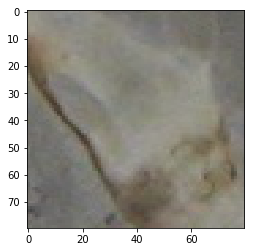

In [19]:
plt.imshow(trainNoPupsIterator.denormalize_input(batch_x[61, ...]))

In [20]:
np.argmax(batch_y, axis=-1).ravel()

array([0, 5, 1, 0, 3, 0, 0, 1, 5, 0, 3, 3, 5, 3, 0, 1, 2, 3, 3, 1, 1, 1, 5,
       1, 3, 0, 3, 0, 1, 3, 5, 0, 0, 2, 0, 5, 3, 3, 3, 2, 3, 5, 5, 1, 5, 3,
       5, 5, 1, 2, 3, 1, 1, 0, 1, 1, 0, 5, 5, 0, 1, 0, 3, 2])

In [21]:
sealion_net.predict(batch_x).shape

(64, 1, 1, 6)

In [22]:
np.sum(sealion_net.predict(batch_x)[0,...]) #check softmax

1.0

In [23]:
from keras.losses import categorical_crossentropy

In [24]:
sgd = SGD(lr=1e-3 , momentum=0.9, decay=1e-6, nesterov=True)
sealion_net.compile(optimizer=sgd, loss=categorical_crossentropy, metrics=['accuracy'])

In [41]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

cb_checkpoint = ModelCheckpoint("/home/ubuntu/data/sealion/data/models/lowik_net/ckpt_{epoch:02d}-{val_loss:.2f}.h5")
cb_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='auto', epsilon=0.01, cooldown=0, min_lr=0)
tensorboard_cb = TensorBoardCallBack(log_dir="/home/ubuntu/data/sealion/data/models/lowik_net/log_tb", batch_freq=10)

In [42]:
h = sealion_net.fit_generator(trainNoPupsIterator, 1000, epochs=20,
                              verbose=1, callbacks=[cb_checkpoint, cb_reduce_lr, tensorboard_cb],
                              validation_data=valNoPupsIterator, validation_steps=200,
                              class_weight=None,
                              max_q_size=16, workers=4, pickle_safe=False,
                              initial_epoch=0)

Epoch 1/20
1000/1000 [==============================] - 267s - loss: 1.5072 - acc: 0.5198 - val_loss: 1.2853 - val_acc: 0.5584
Epoch 2/20
1000/1000 [==============================] - 266s - loss: 1.1566 - acc: 0.5748 - val_loss: 1.1585 - val_acc: 0.5789
Epoch 3/20
1000/1000 [==============================] - 265s - loss: 0.9973 - acc: 0.6163 - val_loss: 0.9991 - val_acc: 0.6050
Epoch 4/20
1000/1000 [==============================] - 266s - loss: 0.9689 - acc: 0.6222 - val_loss: 1.0469 - val_acc: 0.6005
Epoch 5/20
1000/1000 [==============================] - 266s - loss: 0.9065 - acc: 0.6392 - val_loss: 1.0995 - val_acc: 0.5938
Epoch 6/20
1000/1000 [==============================] - 266s - loss: 0.8678 - acc: 0.6516 - val_loss: 0.9787 - val_acc: 0.6083
Epoch 7/20
1000/1000 [==============================] - 266s - loss: 0.8294 - acc: 0.6663 - val_loss: 0.8941 - val_acc: 0.6426
Epoch 8/20
1000/1000 [==============================] - 266s - loss: 0.7994 - acc: 0.6760 - val_loss: 0.9713 - 

In [25]:
from keras.models import load_model

In [74]:
sealion_net = load_model("/home/ubuntu/data/sealion/data/models/lowik_net/ckpt_17-0.78.h5")

In [75]:
for batch_x, batch_y in valNoPupsIterator:
    break

In [76]:
batch_x.shape

(64, 80, 80, 3)

In [77]:
batch_y.shape

(64, 1, 1, 6)

In [78]:
bpred = sealion_net.predict(batch_x)

In [79]:
np.argmax(bpred, axis=-1).ravel()

array([0, 5, 1, 0, 5, 2, 1, 3, 2, 0, 3, 1, 1, 5, 2, 5, 0, 2, 2, 3, 2, 0, 3,
       3, 1, 1, 0, 0, 2, 5, 2, 5, 3, 2, 1, 2, 3, 3, 3, 0, 1, 5, 0, 2, 5, 1,
       0, 1, 2, 2, 5, 3, 4, 2, 5, 5, 2, 1, 0, 1, 1, 1, 0, 1])

In [80]:
np.argmax(batch_y, axis=-1).ravel()

array([0, 5, 3, 1, 5, 2, 0, 3, 0, 1, 2, 1, 0, 5, 2, 5, 1, 3, 1, 3, 0, 1, 2,
       2, 1, 0, 1, 1, 0, 5, 2, 5, 3, 2, 1, 2, 2, 4, 3, 0, 1, 5, 1, 1, 5, 0,
       1, 1, 2, 0, 5, 3, 4, 1, 5, 5, 0, 1, 0, 1, 1, 1, 0, 1])

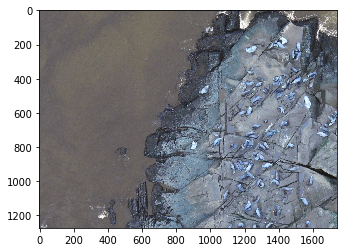

In [105]:
im_val = cv2.imread("/home/ubuntu/sealion/data/TrainBlock/43_5.jpg")

plt.imshow(im_val)

In [106]:
16*51

816

In [107]:
im_val_patch = im_val[:816, -816:, :]
im_val_patch = im_val_patch.reshape((1, 816, 816, 3))

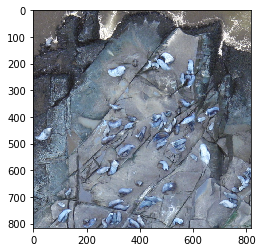

In [108]:
plt.imshow(im_val_patch[0,...])

In [109]:
im_val_pred = sealion_net.predict(trainNoPupsIterator.normalize_input(im_val_patch.astype(np.float32)))

In [110]:
im_val_pred.shape

(1, 47, 47, 6)

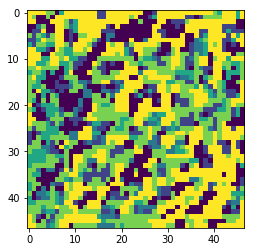

In [111]:
plt.imshow(np.argmax(im_val_pred[0,...], axis=-1))

In [112]:
x = sealion_net.output
x = BatchNormalization(name='bn_heatmap')(x)
x = Conv2D(64, (47, 47), activation='relu', name='cnt_d1')(x)
x = BatchNormalization(name='bn_cnt_d1')(x)
x = Conv2D(32, (1, 1), activation='relu', name='cnt_d2')(x)
counts = Conv2D(5, (1, 1), activation='relu', name='counts')(x)

In [113]:
sealion_count_net = Model(inputs=[sealion_net.input], outputs=[counts])

In [114]:
sealion_count_net.predict(np.ones((1, 816, 816, 3))).shape

(1, 1, 1, 5)

In [115]:
sealion_count_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, None, None, 32)    896       
_________________________________________________________________
bn1_1 (BatchNormalization)   (None, None, None, 32)    128       
_________________________________________________________________
conv1_2 (Conv2D)             (None, None, None, 32)    9248      
_________________________________________________________________
bn1_2 (BatchNormalization)   (None, None, None, 32)    128       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, None, None, 32)    0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, None, None, 64)    18496     
__________

In [116]:
class CountsIterator(Iterator):
    def __init__(self, root_dir, image_ids,
                 n_samples_per_image=160,
                 target_size=(816, 816),
                 batch_size=16, shuffle=True, seed=42, debug_dir=None):
        
        self.n_sealion_types = 5
        self.image_ids = image_ids
        self.root_dir = root_dir
        self.debug_dir = debug_dir
        self.n_samples_per_block = 4
        self.n_samples_per_image = n_samples_per_image
        self.target_size = target_size
        self.n_indices = len(self.image_ids) * self.n_samples_per_image
                 
        super(CountsIterator, self).__init__(self.n_indices, batch_size//self.n_samples_per_block, shuffle, seed)
    
    def normalize_input(self, x_bgr):
        x = x_bgr.copy()
        x[..., 0] -= 103.939
        x[..., 1] -= 116.779
        x[..., 2] -= 123.68
        return x
    
    def denormalize_input(self, x_normed):
        x = x_normed.copy()
        x[..., 0] += 103.939
        x[..., 1] += 116.779
        x[..., 2] += 123.68
        return x

    def random_transform(self, im):
        flips = np.random.randint(0, 2, (3,))
        if flips[0]:
            x = np.rot90(x)
            y = np.rot90(y)
        if flips[1]:
            x = np.flipud(x)
            y = np.flipud(y)
        if flips[2]:
            x = np.fliplr(x)
            y = np.fliplr(y)
        return x, y
    
    def sample(self, im, dots):
        margin = 60
        h, w, c = im.shape
        adots = [d for ds in dots for d in ds]
        rds = np.random.randint(0, len(adots) + 1, size=((self.n_samples_per_block,)))
        batch_x = np.zeros((self.n_samples_per_block, self.target_size[0], self.target_size[1], 3), dtype=np.float32)
        batch_y = np.zeros((self.n_samples_per_block, 5), dtype=np.float32)
        
        n_samples = 0
        while n_samples < self.n_samples_per_block:
            rand_idx = np.random.randint(0, len(adots) + 1, size=((1,)))[0]
            if rand_idx < len(adots):
                x, y = adots[rand_idx]
                xmin = max(0, min(w - self.target_size[1], x - self.target_size[1] + margin))
                xmax = max(0, min(w - self.target_size[1], x - margin))
                ymin = max(0, min(h - self.target_size[0], y - self.target_size[0] + margin))
                ymax = max(0, min(h - self.target_size[0], y - margin))
                if xmin >= xmax or ymin >= ymax:
                    continue
            else:
                xmin, xmax = 0, w - self.target_size[1]
                ymin, ymax = 0, h - self.target_size[0]
            xs = np.random.randint(xmin, xmax, size=(1,))[0]
            ys = np.random.randint(ymin, ymax, size=(1,))[0]
            counts = self.get_counts(xs, ys, dots)                    
            batch_x[n_samples, ...] = im[ys:ys+self.target_size[0], xs:xs+self.target_size[1],...]
            batch_y[n_samples, ...] = np.asarray(counts, dtype=np.float32)
            n_samples += 1
            
        return batch_x, batch_y
    
    def get_counts(self, xstart, ystart, dots):
        x1 = xstart
        y1 = ystart
        x2 = xstart + self.target_size[1]
        y2 = ystart + self.target_size[0]
        counts = [0, 0, 0, 0, 0]
        for i, ds in enumerate(dots):
            for (x, y) in ds:
                if x1 <= x < x2 and y1 <= y < y2:
                    counts[i] += 1
        return counts
        
    def next(self):
        """For python 2.x.
        # Returns
            The next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
                
        batch_x = np.zeros((current_batch_size * self.n_samples_per_block,
                            self.target_size[0],
                            self.target_size[1],
                            3),
                           dtype=K.floatx())
        batch_y = np.zeros((current_batch_size * self.n_samples_per_block, 5),
                           dtype=np.int32)
        
        # For each index, we load the data and sample randomly n_successive_samples patches
        for i, j in enumerate(index_array):
            index = j // self.n_samples_per_image
            image_id = self.image_ids[index]
            with open(os.path.join(self.root_dir, "TrainDots", str(image_id) + ".pkl"), "rb") as pfile:
                dots = pickle.load(pfile)
            im = cv2.imread(os.path.join(self.root_dir, "Train", str(image_id) + ".jpg"))
                
            x, y = self.sample(im, dots)
            batch_x[i*self.n_samples_per_block:(i+1)*self.n_samples_per_block, ...] = x
            batch_y[i*self.n_samples_per_block:(i+1)*self.n_samples_per_block, ...] = y 

        if self.debug_dir:
            for i in range(batch_x.shape[0]):
                cv2.imwrite(os.path.join(self.debug_dir, "patch_{}.jpg".format(i)), batch_x[i])
        
        return self.normalize_input(batch_x), batch_y.reshape(-1, 1, 1, 5)

In [117]:
trainCountsGenerator = CountsIterator("/home/ubuntu/sealion/data/", train_ids)
valCountsGenerator = CountsIterator("/home/ubuntu/sealion/data/", val_ids)

In [118]:
for bx, by in trainCountsGenerator:
    break

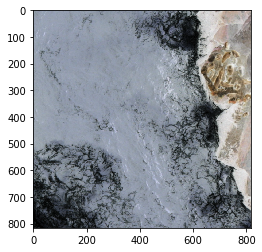

In [119]:
plt.imshow(trainCountsGenerator.denormalize_input(bx)[0])

In [120]:
sealion_count_net.predict(bx).shape

(16, 1, 1, 5)

In [121]:
for l in sealion_count_net.layers:
    l.trainable = False

In [122]:
for l in sealion_count_net.layers[-5:]:
    l.trainable = True

In [123]:
sealion_count_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, None, None, 32)    896       
_________________________________________________________________
bn1_1 (BatchNormalization)   (None, None, None, 32)    128       
_________________________________________________________________
conv1_2 (Conv2D)             (None, None, None, 32)    9248      
_________________________________________________________________
bn1_2 (BatchNormalization)   (None, None, None, 32)    128       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, None, None, 32)    0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, None, None, 64)    18496     
__________

In [124]:
from keras.optimizers import Adadelta

In [125]:
sgd = SGD(lr=1e-5, momentum=0.9, decay=1e-6, nesterov=True)
ad = Adadelta()
sealion_count_net.compile(optimizer=ad, loss=mean_squared_error)

In [126]:
cb_checkpoint_cnt = ModelCheckpoint("/home/ubuntu/data/sealion/data/models/lowik_net/ckpt_cnt_{epoch:02d}-{val_loss:.2f}.h5")
cb_reduce_lr_cnt = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='auto', epsilon=1.0, cooldown=0, min_lr=0)
tensorboard_cb_cnt = TensorBoardCallBack(log_dir="/home/ubuntu/data/sealion/data/models/lowik_net/log_tb_cnt", batch_freq=10)

In [127]:
h_cnt = sealion_count_net.fit_generator(trainCountsGenerator, 1000, epochs=5,
                           verbose=1, callbacks=[cb_checkpoint_cnt, cb_reduce_lr_cnt, tensorboard_cb_cnt],
                           validation_data=valCountsGenerator, validation_steps=100,
                           class_weight=None,
                           max_q_size=4, workers=4, pickle_safe=False,
                           initial_epoch=0)

Epoch 1/5
  53/1000 [>.............................] - ETA: 1719s - loss: 148.2568

KeyboardInterrupt: 

In [ ]:
weights_per_class = mcount/classes_counts

In [ ]:
weights_per_class

In [ ]:
def w_categorical_crossentropy(y_true, y_pred):
    y_true_r = K.reshape(y_true, (8, 212*212, 6))
    y_pred_r = K.reshape(y_pred, (8, 212*212, 6))
    weights = K.max(y_true_r * weights_per_class, axis=-1)
    loss_per_pixel = K.categorical_crossentropy(y_pred_r, y_true_r)
    return loss_per_pixel * weights

In [ ]:
cb_checkpoint = ModelCheckpoint("/home/ubuntu/data/sealion/data/models/segmentation/ckpt_{epoch:02d}-{val_loss:.2f}.h5")
cb_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='auto', epsilon=0.01, cooldown=0, min_lr=0)
tensorboard_cb = TensorBoardCallBack(log_dir="/home/ubuntu/data/sealion/data/models/segmentation/log_tb", batch_freq=10)

In [ ]:
sgd = SGD(lr=1e-2, momentum=0.9, decay=1e-6, nesterov=True)
unet.compile(optimizer=sgd, loss=w_categorical_crossentropy, metrics=["accuracy"])

In [ ]:
h = unet.fit_generator(trainPatchesGenerator, 1000, epochs=20,
                       verbose=1, callbacks=[cb_checkpoint, cb_reduce_lr, tensorboard_cb],
                       validation_data=valPatchesGenerator, validation_steps=200,
                       class_weight=None,
                       max_q_size=16, workers=4, pickle_safe=False,
                       initial_epoch=0)

In [ ]:
h = unet.fit_generator(trainPatchesGenerator, 1000, epochs=10,
                       verbose=1, callbacks=[cb_checkpoint, cb_reduce_lr, tensorboard_cb],
                       validation_data=valPatchesGenerator, validation_steps=200,
                       class_weight=None,
                       max_q_size=16, workers=4, pickle_safe=False,
                       initial_epoch=0)

In [ ]:
for batch_x, batch_y in valPatchesGenerator:
    break

In [ ]:
bpred = unet.predict(batch_x)

In [ ]:
i = 5
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(valPatchesGenerator.denormalize_input(batch_x[i,:,:, :]))
plt.subplot(132)
plt.imshow(to_img(np.argmax(batch_y[i,...], axis=-1)))
plt.subplot(133)
plt.imshow(to_img(np.argmax(bpred[i,...], axis=-1)))

In [ ]:
unet.save("../data/unet_segmentation_ellipse_dmap_sgd_10epochs_200steps.h5")

In [ ]:
for batch_x, batch_y in valPatchesGenerator:
    break

In [ ]:
batch_ypred = unet.predict(batch_x)

In [ ]:
batch_ypred.shape

In [ ]:
np.min(batch_ypred[:,:,2])

In [ ]:
gg = np.argmax(batch_ypred, axis=-1)

In [ ]:
np.unique(gg, return_counts=True)

In [ ]:
i = 0
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(valPatchesGenerator.denormalize_input(batch_x[i,:,:, :]))
plt.subplot(132)
plt.imshow(np.argmax(batch_y[i,...], axis=-1))
plt.subplot(133)
plt.imshow(np.argmax(batch_ypred[i,...], axis=-1))

In [ ]:
plt.imshow(valPatchesGenerator.denormalize_output(batch_ypred[i,:,:, 0]) > 0.0007)

In [ ]:
i = 7
print("GT: ", np.sum(valPatchesGenerator.denormalize_output(batch_y[i,:,:, 0])))
print("Pred: ", np.sum(valPatchesGenerator.denormalize_output(batch_ypred[i,:,:, 0])))

In [ ]:
def full_image_process(im, net, patchGenerator, patch_size=(224, 224), batch_size=8, overlap=(64, 64)):
    h, w, c = im.shape
    n_patches_x = int(np.ceil((w - patch_size[1])/(patch_size[1] - overlap[1]) + 1))
    n_patches_y = int(np.ceil((h - patch_size[0])/(patch_size[0] - overlap[0]) + 1))
    print(n_patches_x, n_patches_x)
    
    dmap = np.zeros((h, w, 1), dtype=np.float32)
    dmap_count = np.zeros((h, w, 1), dtype=np.int8)
    batch_x = np.zeros((batch_size, ) + patch_size + (c, ), dtype=np.float32)
    batch_pos = np.zeros((batch_size, 4), dtype=np.int32)
    
    current_batch_size = 0
    for py in range(n_patches_y):
        y_start = py * (patch_size[0] - overlap[0])
        y_start = min(h - patch_size[0], y_start)
        y_end = y_start + patch_size[0]
        for px in range(n_patches_x):
            x_start = px * (patch_size[1] - overlap[1])
            x_start = min(w - patch_size[1], x_start)
            x_end = x_start + patch_size[1]
            
            # Keep filling the batch
            batch_x[current_batch_size, :, :, :] = im[y_start:y_end, x_start:x_end, :]
            batch_pos[current_batch_size, :] = np.array([y_start, y_end, x_start, x_end])
            current_batch_size += 1
            
            if current_batch_size == batch_size or (py == n_patches_y - 1 and px == n_patches_x - 1) :
                # time to predict
                batch_x_normed = patchGenerator.normalize_input(batch_x)
                batch_ylog = net.predict(batch_x_normed)
                batch_y = patchGenerator.denormalize_output(batch_ylog)
                # Fill the full dmap
                for i in range(current_batch_size):
                    y_start, y_end, x_start, x_end = tuple(batch_pos[i,:])
                    dmap[y_start:y_end, x_start:x_end, :] += batch_y[i,:,:,:]
                    dmap_count[y_start:y_end, x_start:x_end] += 1
                current_batch_size = 0
                
    return dmap, dmap_count

In [ ]:
im = cv2.imread("../data/sealion/Train/872.jpg")

In [ ]:
dmap, dmap_count = full_image_process(im, unet, valPatchesGenerator)

In [ ]:
plt.imshow(dmap[:,:,0])

In [ ]:
dmap_avg = dmap/dmap_count

In [ ]:
dmap_count.shape

In [ ]:
np.sum(dmap)

In [ ]:
np.sum(dmap_avg)

In [ ]:
dmap_gt = np.load("../data/sealion/TrainDensity/872_0.npz")